Yalnızca tek bir katman içeren İleri Beslemeli Sinir Ağı modeli

Gereksinimler:

In [ ]:
!pip install numpy
!pip install opencv-python
!pip install pandas
!pip install tensorflow
!pip install keras
!pip install pillow

Veriyi zip'ten çıkarma:

In [2]:
import zipfile

# zip dosyasının yolu
zip_file_path = "/content/drive/MyDrive/ChestXray.zip"

# zip dosyasını aç
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/veri")

Veriyi parçalara bölme:

In [3]:
import os
import shutil
import random
from PIL import Image

#Olması beklenen yolları tanımla
data_dir = '/content/veri/ChestXray'
train_dir = 'train'
test_dir = 'test'
img_size=(256,256)
# Class isimleri
class_names = ['NORMAL', 'PNEUMONIA']

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in class_names:
    train_subdir = os.path.join(train_dir, class_name)
    test_subdir = os.path.join(test_dir, class_name)
    os.makedirs(train_subdir, exist_ok=True)
    os.makedirs(test_subdir, exist_ok=True)

# Resimleri %80 oranla ilgili klasörlerin içine böl
for class_name in class_names:
    source_dir = os.path.join(data_dir, class_name)
    images = os.listdir(source_dir)
    train_size = int(0.8 * len(images))
    random.shuffle(images)
    train_images = images[:train_size]
    test_images = images[train_size:]
    for image_name in train_images:
        source_path = os.path.join(source_dir, image_name)
        target_path = os.path.join(train_dir, class_name, image_name)
        with Image.open(source_path) as img:
            img = img.resize((img_size[0], img_size[1]))
            img.save(target_path)
    for image_name in test_images:
        source_path = os.path.join(source_dir, image_name)
        target_path = os.path.join(test_dir, class_name, image_name)
        with Image.open(source_path) as img:
            img = img.resize((img_size[0], img_size[1]))
            img.save(target_path)

In [6]:
import cv2

image_path = "/content/test/NORMAL/IM-0006-0001.jpeg"
image = cv2.imread(image_path)
print("Resmin shape'i:", image.shape)
cv2.destroyAllWindows()

Resmin shape'i: (256, 256, 3)


Veri üzerinde normalizasyon:

In [7]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/train'
test_dir = '/content/test'

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=(img_size[0], img_size[1]), batch_size=32, class_mode='binary')
test_data = datagen.flow_from_directory(test_dir, target_size=(img_size[0], img_size[1]), batch_size=32, class_mode='binary')


Found 2633 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


Resnet50 modeli ve eğitim:

In [8]:
# CNN modelinin oluşturulması ve eğitilmesi
from keras.applications import ResNet50
from keras.layers import Dense, Flatten
from keras.models import Model

resnet = ResNet50(weights=None, include_top=True, input_shape=(img_size[0], img_size[1], 3))

for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = Flatten()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=resnet.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, epochs=30, validation_data=test_data)

Epoch 1/30
83/83 [==============================] - 28s 188ms/step - loss: 0.6929 - accuracy: 0.5161 - val_loss: 0.6926 - val_accuracy: 0.5190
Epoch 2/30
83/83 [==============================] - 13s 158ms/step - loss: 0.6927 - accuracy: 0.5192 - val_loss: 0.6925 - val_accuracy: 0.5190
Epoch 3/30
83/83 [==============================] - 13s 159ms/step - loss: 0.6925 - accuracy: 0.5192 - val_loss: 0.6924 - val_accuracy: 0.5190
Epoch 4/30
83/83 [==============================] - 13s 160ms/step - loss: 0.6925 - accuracy: 0.5192 - val_loss: 0.6924 - val_accuracy: 0.5190
Epoch 5/30
83/83 [==============================] - 14s 163ms/step - loss: 0.6925 - accuracy: 0.5192 - val_loss: 0.6924 - val_accuracy: 0.5190
Epoch 6/30
83/83 [==============================] - 14s 164ms/step - loss: 0.6924 - accuracy: 0.5192 - val_loss: 0.6924 - val_accuracy: 0.5190
Epoch 7/30
83/83 [==============================] - 14s 166ms/step - loss: 0.6925 - accuracy: 0.5192 - val_loss: 0.6924 - val_accuracy: 0.5190

Loss-Accuracy tablosu:

<Axes: >

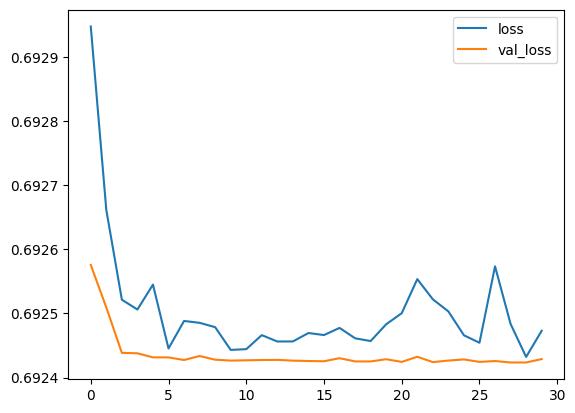

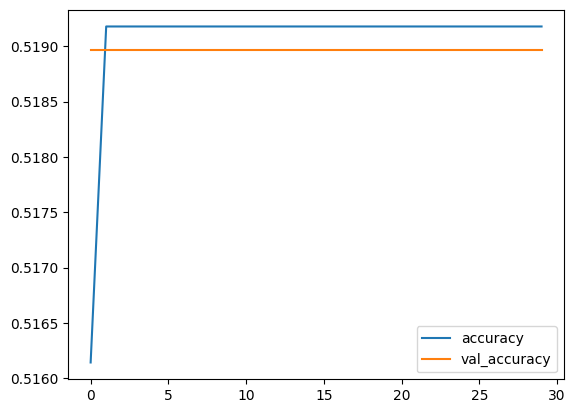

In [10]:
import pandas as pd
df = pd.DataFrame(model.history.history)
loss=df.drop(["accuracy","val_accuracy"],axis=1)
accuracy=df.drop(["loss","val_loss"],axis=1)
loss.plot()
accuracy.plot()

Test:

In [12]:
loss, accuracy = model.evaluate(test_data)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

21/21 [==============================] - 3s 129ms/step - loss: 0.6924 - accuracy: 0.5190
Test Loss: 0.6924288272857666
Test Accuracy: 0.5189681053161621
